In [25]:
import os
import json
import base64
import tempfile
from io import BytesIO
from dotenv import load_dotenv
from openai import OpenAI
from PIL import Image
from IPython.display import Audio, display
import gradio as gr
import google.generativeai as genai

In [26]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Google API Key exists and begins AIzaSyAl


In [3]:
MODEL = "gpt-4o-mini"
openai = OpenAI()

In [4]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [5]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [6]:
get_ticket_price("london")

Tool get_ticket_price called for london


'$799'

In [7]:
def make_booking(destination_city,passenger_name):
    booking = {"destination_city": destination_city, "passenger_name": passenger_name}
    with open("bookings.txt", "a") as f:
        f.write(json.dumps(booking) + "\n")
    return f"Booking confirmed for {passenger_name} to {destination_city}."

In [8]:
make_booking("London","Omkar")

'Booking confirmed for Omkar to London.'

In [9]:
price_function = {
    "name": "get_ticket_price",
    "decription": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to", 
            },
        }, 
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

booking_function = {
    "name": "make_booking",
    "description": "Make a flight booking for the customer.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {"type": "string", "description": "Destination city for the booking"},
            "passenger_name": {"type": "string", "description": "Name of the passenger"}
        },
        "required": ["destination_city", "passenger_name"],
        "additionalProperties": False
    }
}

In [10]:
tools = [{"type": "function", "function": price_function}, {"type": "function", "function": booking_function}]

In [11]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)

    if tool_call.function.name == "get_ticket_price":
        city = arguments.get('destination_city')
        price = get_ticket_price(city)
        response = {
            "role": "tool",
            "content": json.dumps({"destination_city":city, "price":price}),
            "tool_call_id": tool_call.id 
        }
        return response, city

    elif tool_call.function.name == "make_booking":
        city = arguments.get('destination_city')
        name = arguments.get('passenger_name')
        confirmation = make_booking(city, name)
        response = {
            "role" : "tool",
            "content": json.dumps({"destination_city":city, "passenger_name":name,"confirmation": confirmation}),
            "tool_call_id": tool_call.id
        }
        return response, city

In [12]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image



In [13]:
def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

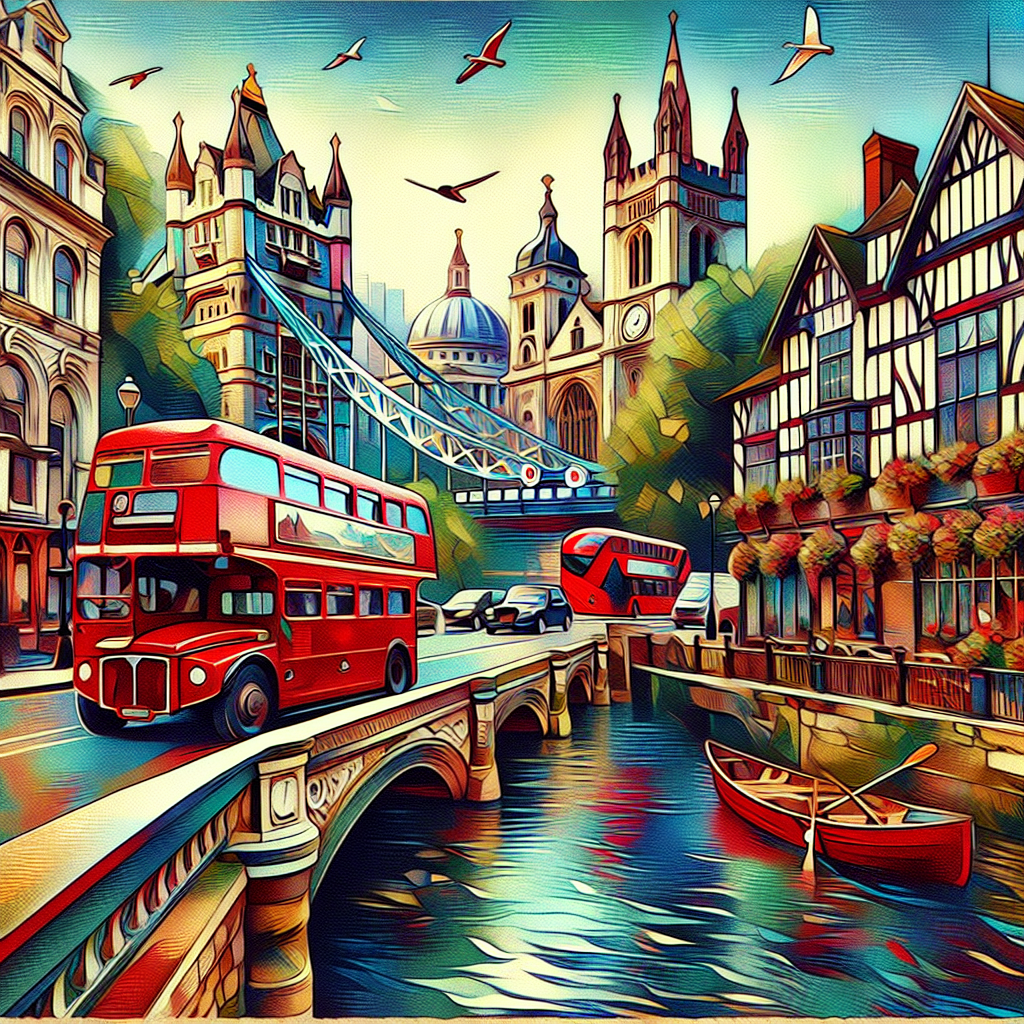

In [37]:
display(artist("london"))

In [14]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 7.1.1-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enable-d3d12va --enable-ffnvcodec --enable-libvpl --enable-nvdec --enable-nvenc --enable-vaapi --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --ena

In [15]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

In [20]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [37]:
import os
from openai import OpenAI

# Load your Google API Key securely from environment variables
google_api_key = os.getenv("GOOGLE_API_KEY")

client = OpenAI(
    api_key=google_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

def translate_text(text, target_language="French"):
    response = client.chat.completions.create(
        model="gemini-1.5-pro",  # or "gemini-2.0-flash" if preferred
        n=1,
        messages=[
            {"role": "system", "content": "You are a helpful translator."},
            {"role": "user", "content": f"Translate the following English sentence to {target_language}:\n\n{text}"}
        ]
    )
    return response.choices[0].message.content.strip()


In [38]:
# Audio-to-text

def transcribe_audio(audio):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as temp_audio:
        temp_audio.write(audio)
        temp_audio_path = temp_audio.name

    with open(temp_audio_path, "rb") as f:
        transcript = openai.audio.transcriptions.create(model="whisper-1", file=f)
    return transcript.text


In [39]:
MODEL = "gpt-4o-mini"# Main chat logic
def chat(history):
    try:
        messages = [{"role": "system", "content": system_message}] + history
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
        image = None
        translated = ""

        if response.choices[0].finish_reason == "tool_calls":
            message = response.choices[0].message
            tool_response, city = handle_tool_call(message)
            messages.append(message)
            messages.append(tool_response)
            image = artist(city)
            response = openai.chat.completions.create(model=MODEL, messages=messages)

        reply = response.choices[0].message.content
        translated = translate_text(reply, "French")
        history += [{"role": "assistant", "content": reply}]
        talker(reply)
        return history, image, translated
    except Exception as e:
        print("Error in chat():", e)
        return history, None, f"Error: {e}"


In [40]:
# Gradio UI
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
        translation_output = gr.Textbox(label="Translation", lines=10)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        mic = gr.Audio(type="filepath", label="Speak your query")

    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role": "user", "content": message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output, translation_output]
    )
    mic.change(fn=transcribe_audio, inputs=[mic], outputs=[entry])
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Paris
